# 08. Hybrid Ensemble & Business Impact Analysis

This notebook implements a **Hybrid Ensemble Model** combining the strengths of Gradient Boosting (LightGBM) and Sequence Modeling (GRU). It also includes a **Business ROI Simulation** to translate model probabilities into actionable financial insights for the Customer Experience (CX) team.

In [1]:
import pandas as pd
import numpy as np
import pickle
import json
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, auc, brier_score_loss
import lightgbm as lgb

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

## 1. Load Data
We load the same preprocessed test set used for other models.

In [2]:
with open('../data/processed/churn_data.pkl', 'rb') as f:
    data = pickle.load(f)

X_test_tabular = data['X_test_scaled']
y_test = data['y_test']

# Prepare Sequential Data for GRU (Batch, Seq_Len=15, Feats)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_test_tensor = torch.FloatTensor(X_test_tabular).unsqueeze(1).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

## 2. Load Models & Generate Predictions

In [3]:
# 1. Load LightGBM
with open('../results/models/lightgbm/lightgbm.pkl', 'rb') as f:
    lgbm_model = pickle.load(f)

p_lgbm = lgbm_model.predict_proba(X_test_tabular)[:, 1]

# 2. Load GRU
# Define architecture exactly as in 05_gru_model
class GRUChurnModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(GRUChurnModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(
            input_size, hidden_size, num_layers, 
            batch_first=True, dropout=dropout
        )
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out.squeeze()

# Instantiate with Correct Hyperparams from 05_gru_model
input_size = X_test_tabular.shape[1]
gru_model = GRUChurnModel(input_size, hidden_size=256, num_layers=2, dropout=0.01).to(device)

# Load Weights
gru_model.load_state_dict(torch.load('../results/models/gru/gru_best_model.pt', map_location=device))
gru_model.eval()

with torch.no_grad():
    logits_gru = gru_model(X_test_tensor)
    p_gru = torch.sigmoid(logits_gru).cpu().numpy().flatten()

# Check correlation
corr = np.corrcoef(p_lgbm, p_gru)[0, 1]
print(f"Correlation between LightGBM and GRU predictions: {corr:.4f}")

Correlation between LightGBM and GRU predictions: 0.7117


/Users/linoospaulinos/miniforge3/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## 3. Hybrid Ensemble (Weighted Average)

In [4]:
# Simple weighted average
# LightGBM had 0.80 AUC, GRU had ~0.73. We give more weight to LightGBM.
w_lgbm = 0.7
w_gru = 0.3

p_ensemble = (w_lgbm * p_lgbm) + (w_gru * p_gru)

roc_auc = roc_auc_score(y_test, p_ensemble)
precision, recall, _ = precision_recall_curve(y_test, p_ensemble)
pr_auc = auc(recall, precision)
brier = brier_score_loss(y_test, p_ensemble)

print(f"Hybrid Ensemble ROC-AUC: {roc_auc:.4f}")
print(f"Hybrid Ensemble PR-AUC:  {pr_auc:.4f}")
print(f"Hybrid Ensemble Brier:   {brier:.4f}")

Hybrid Ensemble ROC-AUC: 0.7564
Hybrid Ensemble PR-AUC:  0.8056
Hybrid Ensemble Brier:   0.1928


## 4. Business ROI Simulation

We calculate the Expected Value of an intervention.
- **Cost of Intervention**: €10 (e.g., call time, discount).
- **Value of Saved Churn**: €500 (LTV).
- **Success Rate of Intervention**: 20% (Assumed uplift).

Formula: `Net Value = (Prob_Churn * Success_Rate * LTV) - Cost`

We intervene if `Net Value > 0`.

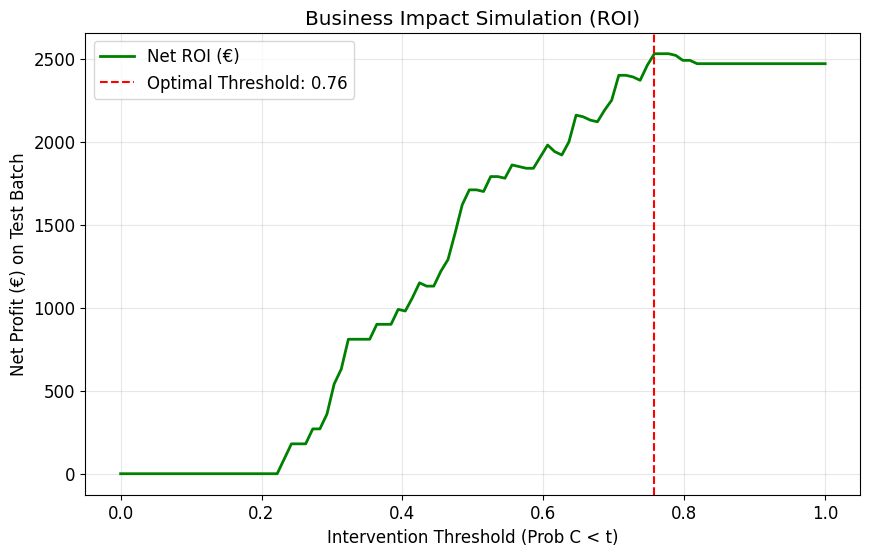

Optimal Threshold: 0.76
Max Net ROI on Test Set: €2530.00


In [5]:
cost_intervention = 10
value_saved = 500
success_rate = 0.20

# Prob of Churn = 1 - Prob of Conversion
prob_churn = 1 - p_ensemble

thresholds = np.linspace(0, 1, 100)
roi_values = []

for t in thresholds:
    # Policy: Intervene if Prob_Conversion < t (i.e., Risk is higher)
    interventions = (p_ensemble < t)
    n_interventions = interventions.sum()
    
    actual_churners = (y_test == 0)
    potential_saves = interventions & actual_churners
    n_saved = potential_saves.sum() * success_rate
    
    total_cost = n_interventions * cost_intervention
    total_gain = n_saved * value_saved
    net_roi = total_gain - total_cost
    roi_values.append(net_roi)

best_t = thresholds[np.argmax(roi_values)]
max_roi = max(roi_values)

plt.figure(figsize=(10,6))
plt.plot(thresholds, roi_values, label='Net ROI (€)', color='green', linewidth=2)
plt.axvline(best_t, color='red', linestyle='--', label=f'Optimal Threshold: {best_t:.2f}')
plt.title('Business Impact Simulation (ROI)')
plt.xlabel('Intervention Threshold (Prob C < t)')
plt.ylabel('Net Profit (€) on Test Batch')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../results/figures/comparison/roi_simulation.png')
plt.show()

print(f"Optimal Threshold: {best_t:.2f}")
print(f"Max Net ROI on Test Set: €{max_roi:.2f}")